In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")


In [3]:
df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv")
print(df['Label'].value_counts())

Label
Benign                      621372
DDOS attack-HOIC            343006
DoS attacks-Hulk            230956
Bot                         143096
DoS attacks-SlowHTTPTest     69945
Infilteration                46532
DDOS attack-LOIC-UDP           865
Label                           13
Name: count, dtype: int64


In [4]:
sample_size = 50000
df_balanced = pd.DataFrame()

for label in df['Label'].unique():
    df_label = df[df['Label'] == label]
    if len(df_label) > sample_size:
        df_sample = df_label.sample(sample_size, random_state=42)
    else:
        df_sample = df_label
    df_balanced = pd.concat([df_balanced, df_sample])

df_balanced = df_balanced.reset_index(drop=True)

df = df_balanced

print(df['Label'].value_counts())
print(df.shape)

Label
Benign                      50000
Bot                         50000
DDOS attack-HOIC            50000
DoS attacks-Hulk            50000
DoS attacks-SlowHTTPTest    50000
Infilteration               46532
DDOS attack-LOIC-UDP          865
Label                          13
Name: count, dtype: int64
(297410, 80)


In [5]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,64986,6,21/02/2018 02:22:13,5046,5,2,935.0,249.0,935.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,55180,6,16/02/2018 01:46:27,5125251,5,4,935.0,372.0,935.0,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,48494,6,16/02/2018 01:48:32,4120530,5,3,935.0,306.0,935.0,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,38586,6,16/02/2018 01:47:04,4305517,5,4,935.0,323.0,935.0,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,50594,6,01/03/2018 10:04:16,17,1,1,0.0,0.0,0.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297410 entries, 0 to 297409
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Dst Port           297410 non-null  object
 1   Protocol           297410 non-null  object
 2   Timestamp          297410 non-null  object
 3   Flow Duration      297410 non-null  object
 4   Tot Fwd Pkts       297410 non-null  object
 5   Tot Bwd Pkts       297410 non-null  object
 6   TotLen Fwd Pkts    297410 non-null  object
 7   TotLen Bwd Pkts    297410 non-null  object
 8   Fwd Pkt Len Max    297410 non-null  object
 9   Fwd Pkt Len Min    297410 non-null  object
 10  Fwd Pkt Len Mean   297410 non-null  object
 11  Fwd Pkt Len Std    297410 non-null  object
 12  Bwd Pkt Len Max    297410 non-null  object
 13  Bwd Pkt Len Min    297410 non-null  object
 14  Bwd Pkt Len Mean   297410 non-null  object
 15  Bwd Pkt Len Std    297410 non-null  object
 16  Flow Byts/s        2

In [7]:
duplicates = df[df.duplicated(keep=False)]
print("Duplicate rows count:", len(duplicates))

Duplicate rows count: 45339


In [8]:
df.drop(columns=['Timestamp'], inplace=True)


exclude_cols = ['Label']


cols = df.columns.difference(exclude_cols)

def convert_col(col):

    try:

        temp = pd.to_numeric(df[col], errors='coerce')

        if temp.dropna().apply(lambda x: x.is_integer()).all():
            return temp.astype('Int64')
        else:
            return temp.astype('float32')
    except:

        return df[col]


for col in cols:
    df[col] = convert_col(col)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297410 entries, 0 to 297409
Data columns (total 79 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           297397 non-null  Int64  
 1   Protocol           297397 non-null  Int64  
 2   Flow Duration      297397 non-null  Int64  
 3   Tot Fwd Pkts       297397 non-null  Int64  
 4   Tot Bwd Pkts       297397 non-null  Int64  
 5   TotLen Fwd Pkts    297397 non-null  Int64  
 6   TotLen Bwd Pkts    297397 non-null  Int64  
 7   Fwd Pkt Len Max    297397 non-null  Int64  
 8   Fwd Pkt Len Min    297397 non-null  Int64  
 9   Fwd Pkt Len Mean   297397 non-null  float32
 10  Fwd Pkt Len Std    297397 non-null  float32
 11  Bwd Pkt Len Max    297397 non-null  Int64  
 12  Bwd Pkt Len Min    297397 non-null  Int64  
 13  Bwd Pkt Len Mean   297397 non-null  float32
 14  Bwd Pkt Len Std    297397 non-null  float32
 15  Flow Byts/s        297109 non-null  float32
 16  Fl

In [10]:

nan_mask = df.isna()
nan_rows = nan_mask.any(axis=1).sum()

num_cols = df.select_dtypes(include=[np.number]).columns
inf_mask = pd.DataFrame(False, index=df.index, columns=df.columns)
if len(num_cols) > 0:
    inf_mask[num_cols] = df[num_cols].applymap(np.isinf)
inf_rows = inf_mask.any(axis=1).sum()

print(f"nan: {nan_rows}")
print(f"inf: {inf_rows}")


nan: 301
inf: 471


In [11]:
rows_to_drop = (nan_mask | inf_mask).any(axis=1)

df_clean = df.loc[~rows_to_drop].reset_index(drop=True)

In [12]:

nan_mask = df_clean.isna()
nan_rows = nan_mask.any(axis=1).sum()

In [13]:
print(f"nan: {nan_rows}")

nan: 0


Flow Duration : 
1. Bağlantıların büyük kısmı (%80.24) uzun süreli (60 saniyeden fazla):
Bu, veri setinde çok uzun süre açık kalan bağlantıların baskın olduğunu gösteriyor.

Bu tür bağlantılar genelde sunucu trafiği, VPN, dosya transferleri ya da persistent saldırılar (örneğin DoS, DDoS) olabilir.

Model bu tür uzun bağlantılara alışık hale gelmişse, kısa süreli anormal trafiği tespit etmesi zorlaşabilir.

2. Kısa (1-10s) ve çok kısa (0-1s) bağlantılar azınlıkta:
Sadece %16.6'lık kısmı kısa sürelidir.

Bu bağlantılar çoğunlukla web trafiği, ping taramaları, port scan gibi kısa süreli saldırılar ya da normal aktiviteler olabilir.

Bu oran düşük olduğu için, modelin bu tip örnekleri öğrenmesi daha zor olabilir (dengesizlik sorunu).


Dst Port : 
Veri seti, web tabanlı servislerin yoğun kullanıldığı bir ağ ortamına işaret ediyor.

HTTP ve FTP trafiğinin yüksek oranı, saldırganların bu servisleri hedef aldığı bir ortamı gösteriyor olabilir.

Toplam port sayısının fazla olması, olasılıkla tarama (scan) aktiviteleri içerdiğini gösteriyor — modelde Dst Port özelliği, bu yüzden önemli bir ayrıştırıcı olabilir.

Protocol : 
Ağ trafiğinin %93’ü TCP ile taşınıyor; bu, TCP bazlı saldırıların ve güvenilir bağlantılara dayalı servislerin (HTTP, HTTPS, FTP, SSH vb.) yoğunlukta olduğunu gösteriyor.  UDP ve tanımsız protokoller düşük oranda ama anomali tespiti için kritik olabilir. Bu oranın düşük olması, ağda akışa duyarlı (reliable) uygulamaların baskın olduğunu gösterir.

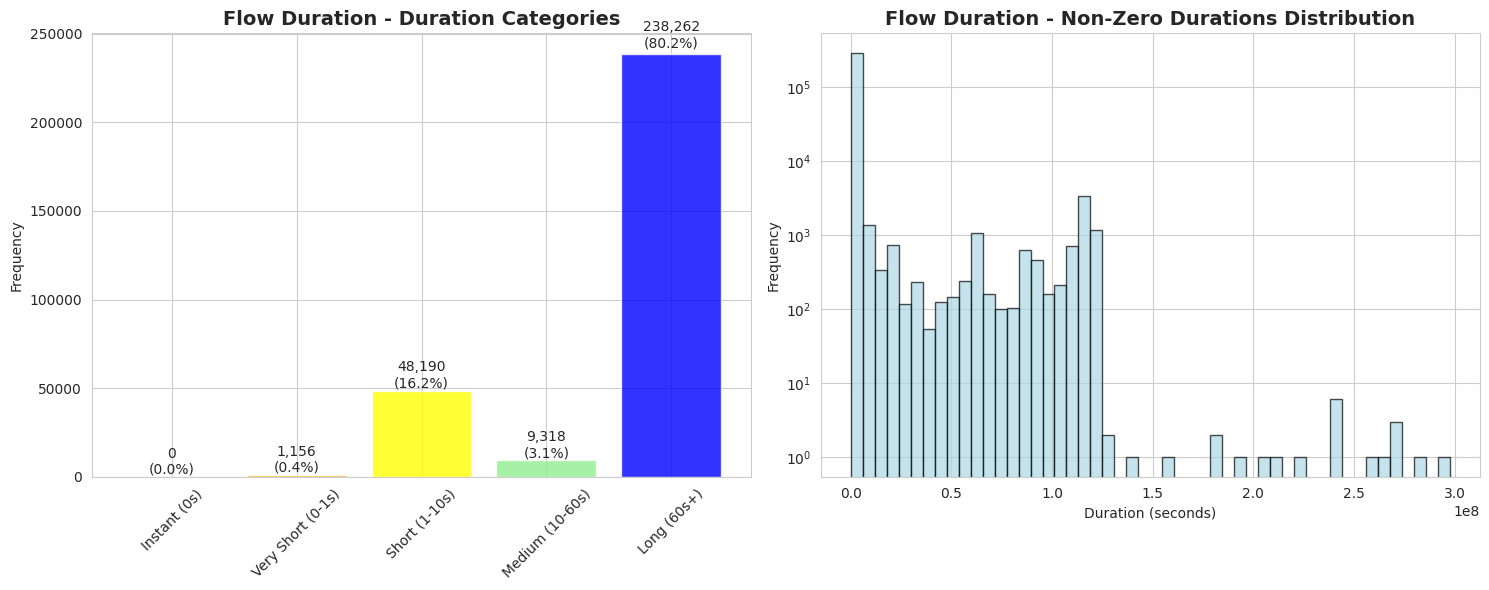


 Flow Duration DURATION ANALYSIS:
  Instant (0s): 0 connections (0.00%)
  Very Short (0-1s): 1,156 connections (0.39%)
  Short (1-10s): 48,190 connections (16.23%)
  Medium (10-60s): 9,318 connections (3.14%)
  Long (60s+): 238,262 connections (80.24%)
  Average duration: 3458472.444 seconds
  Median duration: 2852.000 seconds
  Max duration: 297759999.000 seconds
------------------------------------------------------------


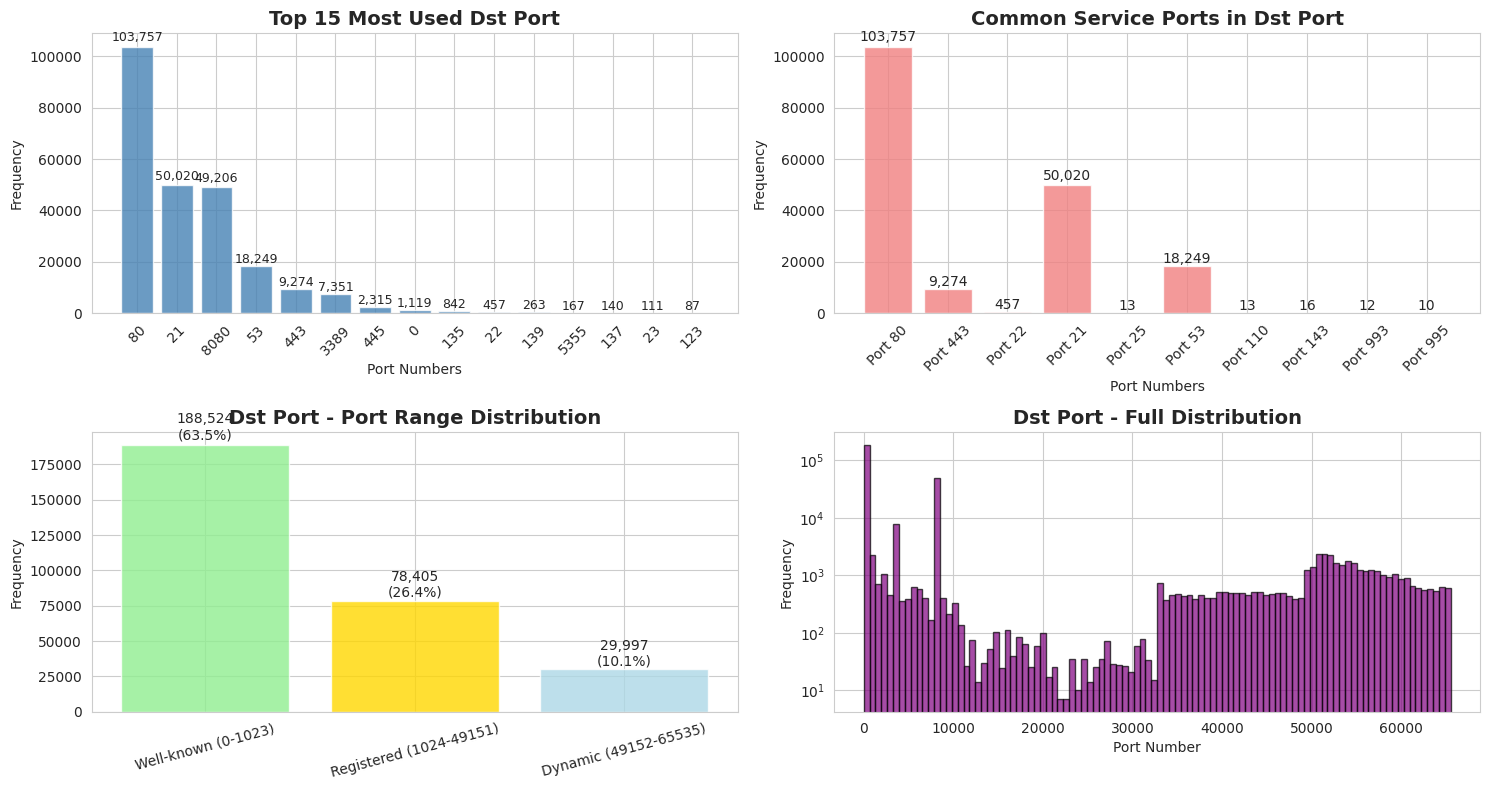


 Dst Port DETAILED ANALYSIS:
Total unique ports: 20236
Top 5 most used ports:
  1. Port 80: 103,757 times (34.94%)
  2. Port 21: 50,020 times (16.85%)
  3. Port 8080: 49,206 times (16.57%)
  4. Port 53: 18,249 times (6.15%)
  5. Port 443: 9,274 times (3.12%)
------------------------------------------------------------


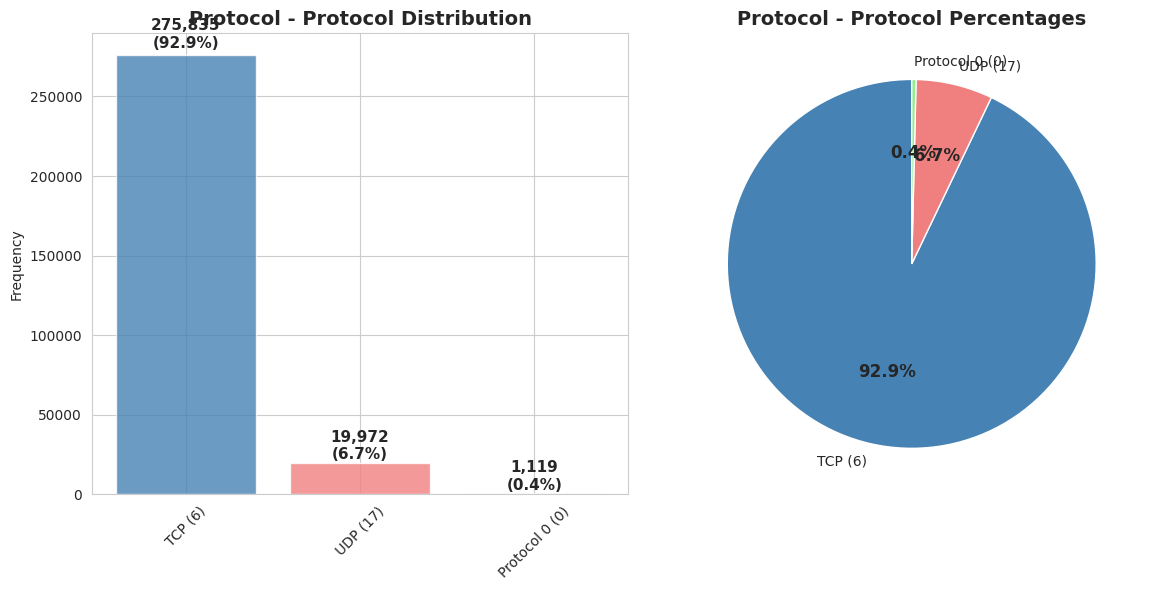


Protocol PROTOCOL ANALYSIS:
  TCP (ID: 6): 275,835 packets (92.90%)
  UDP (ID: 17): 19,972 packets (6.73%)
  Unknown Protocol (ID: 0): 1,119 packets (0.38%)
------------------------------------------------------------


In [24]:
def traffic_analysis_focused(df):

    duration_cols = [col for col in df.columns if 'duration' in col.lower()]

    for col in duration_cols:
        plt.figure(figsize=(15, 6))


        duration_categories = {
            'Instant (0s)': (df[col] == 0).sum(),
            'Very Short (0-1s)': ((df[col] > 0) & (df[col] <= 1)).sum(),
            'Short (1-10s)': ((df[col] > 1) & (df[col] <= 10)).sum(),
            'Medium (10-60s)': ((df[col] > 10) & (df[col] <= 60)).sum(),
            'Long (60s+)': (df[col] > 60).sum()
        }

        plt.subplot(1, 2, 1)
        colors = ['red', 'orange', 'yellow', 'lightgreen', 'blue']
        bars = plt.bar(duration_categories.keys(), duration_categories.values(),
                      color=colors, alpha=0.8)
        plt.title(f'{col} - Duration Categories', fontsize=14, fontweight='bold')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)


        total = sum(duration_categories.values())
        for i, bar in enumerate(bars):
            height = bar.get_height()
            percentage = (height/total)*100
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{int(height):,}\n({percentage:.1f}%)',
                    ha='center', va='bottom', fontsize=10)


        plt.subplot(1, 2, 2)
        non_zero_durations = df[df[col] > 0][col]
        if len(non_zero_durations) > 0:
            plt.hist(non_zero_durations, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
            plt.title(f'{col} - Non-Zero Durations Distribution', fontsize=14, fontweight='bold')
            plt.xlabel('Duration (seconds)')
            plt.ylabel('Frequency')
            plt.yscale('log')

        plt.tight_layout()
        plt.show()

        print(f"\n {col} DURATION ANALYSIS:")
        for category, count in duration_categories.items():
            percentage = (count / len(df)) * 100
            print(f"  {category}: {count:,} connections ({percentage:.2f}%)")
        print(f"  Average duration: {df[col].mean():.3f} seconds")
        print(f"  Median duration: {df[col].median():.3f} seconds")
        print(f"  Max duration: {df[col].max():.3f} seconds")
        print("-" * 60)

    dst_port_cols = [col for col in df.columns if 'dst' in col.lower() and 'port' in col.lower()]

    for col in dst_port_cols:
        plt.figure(figsize=(15, 8))


        top_dst_ports = df[col].value_counts().head(15)

        plt.subplot(2, 2, 1)
        bars = plt.bar(range(len(top_dst_ports)), top_dst_ports.values, color='steelblue', alpha=0.8)
        plt.title(f'Top 15 Most Used {col}', fontsize=14, fontweight='bold')
        plt.xlabel('Port Numbers')
        plt.ylabel('Frequency')
        plt.xticks(range(len(top_dst_ports)), top_dst_ports.index, rotation=45)


        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=9)

        plt.subplot(2, 2, 2)
        important_ports = [80, 443, 22, 21, 25, 53, 110, 143, 993, 995]
        port_counts = []
        port_labels = []

        for port in important_ports:
            count = (df[col] == port).sum()
            if count > 0:
                port_counts.append(count)
                port_labels.append(f'Port {port}')

        if port_counts:
            bars = plt.bar(port_labels, port_counts, color='lightcoral', alpha=0.8)
            plt.title(f'Common Service Ports in {col}', fontsize=14, fontweight='bold')
            plt.xlabel('Port Numbers')
            plt.ylabel('Frequency')
            plt.xticks(rotation=45)


            for i, bar in enumerate(bars):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                        f'{int(height):,}', ha='center', va='bottom', fontsize=10)


        plt.subplot(2, 2, 3)
        port_ranges = {
            'Well-known (0-1023)': ((df[col] >= 0) & (df[col] <= 1023)).sum(),
            'Registered (1024-49151)': ((df[col] >= 1024) & (df[col] <= 49151)).sum(),
            'Dynamic (49152-65535)': ((df[col] >= 49152) & (df[col] <= 65535)).sum()
        }

        colors = ['lightgreen', 'gold', 'lightblue']
        bars = plt.bar(port_ranges.keys(), port_ranges.values(), color=colors, alpha=0.8)
        plt.title(f'{col} - Port Range Distribution', fontsize=14, fontweight='bold')
        plt.ylabel('Frequency')
        plt.xticks(rotation=15)


        total = sum(port_ranges.values())
        for i, bar in enumerate(bars):
            height = bar.get_height()
            percentage = (height/total)*100
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{int(height):,}\n({percentage:.1f}%)',
                    ha='center', va='bottom', fontsize=10)


        plt.subplot(2, 2, 4)
        plt.hist(df[col], bins=100, alpha=0.7, color='purple', edgecolor='black')
        plt.title(f'{col} - Full Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Port Number')
        plt.ylabel('Frequency')
        plt.yscale('log')

        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"\n {col} DETAILED ANALYSIS:")
        print(f"Total unique ports: {df[col].nunique()}")
        print(f"Top 5 most used ports:")
        for i, (port, count) in enumerate(top_dst_ports.head().items(), 1):
            percentage = (count / len(df)) * 100
            print(f"  {i}. Port {port}: {count:,} times ({percentage:.2f}%)")
        print("-" * 60)

    # 3. PROTOCOL ANALYSIS
    protocol_cols = [col for col in df.columns if 'protocol' in col.lower()]

    for col in protocol_cols:
        plt.figure(figsize=(12, 6))

        protocol_counts = df[col].value_counts()
        protocol_names = {6: 'TCP', 17: 'UDP', 1: 'ICMP', 2: 'IGMP'}

        plt.subplot(1, 2, 1)

        labels = [f'{protocol_names.get(p, f"Protocol {p}")} ({p})' for p in protocol_counts.index]
        bars = plt.bar(labels, protocol_counts.values,
                      color=['steelblue', 'lightcoral', 'lightgreen', 'gold'][:len(protocol_counts)],
                      alpha=0.8)
        plt.title(f'{col} - Protocol Distribution', fontsize=14, fontweight='bold')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)

        total = protocol_counts.sum()
        for i, bar in enumerate(bars):
            height = bar.get_height()
            percentage = (height/total)*100
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{int(height):,}\n({percentage:.1f}%)',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

        plt.subplot(1, 2, 2)
        colors = ['steelblue', 'lightcoral', 'lightgreen', 'gold'][:len(protocol_counts)]
        wedges, texts, autotexts = plt.pie(protocol_counts.values,
                                          labels=labels,
                                          autopct='%1.1f%%',
                                          colors=colors,
                                          startangle=90)
        plt.title(f'{col} - Protocol Percentages', fontsize=14, fontweight='bold')

        for autotext in autotexts:
            autotext.set_fontsize(12)
            autotext.set_fontweight('bold')

        plt.tight_layout()
        plt.show()

        print(f"\n{col} PROTOCOL ANALYSIS:")
        for protocol, count in protocol_counts.items():
            protocol_name = protocol_names.get(protocol, f"Unknown Protocol")
            percentage = (count / len(df)) * 100
            print(f"  {protocol_name} (ID: {protocol}): {count:,} packets ({percentage:.2f}%)")
        print("-" * 60)


traffic_analysis_focused(df_clean)

Korelasyon analizi sonucunda, bazı özellik çiftleri arasında **neredeyse bire bir ilişki** tespit edilmiştir. Bu tür yüksek korelasyonlar (|r| ≈ 1.0), modelin öğrenme sürecini etkileyebilir ve **aşırı bilgi tekrarı (redundancy)** yaratabilir. Özellikle karar ağaçları dışındaki modeller (örneğin: Lojistik Regresyon, SVM) bu durumdan olumsuz etkilenebilir.

- Bu kadar yüksek korelasyona sahip değişkenlerden bazıları **model öncesi çıkarılabilir (feature elimination)**.
- Alternatif olarak, **PCA (Principal Component Analysis)** gibi boyut indirgeme teknikleri düşünülebilir.
- Ancak, bazı modeller (örneğin: Random Forest, XGBoost) bu korelasyonları toleranslı bir şekilde öğrenebildiğinden, seçilecek model türüne göre karar verilmelidir.

Fakat yapılan akademik çalışmalar incelendiğinde bu şekilde kullanılmasında da bir problem görülmemiştir bunlar yalnızca öneridir. 

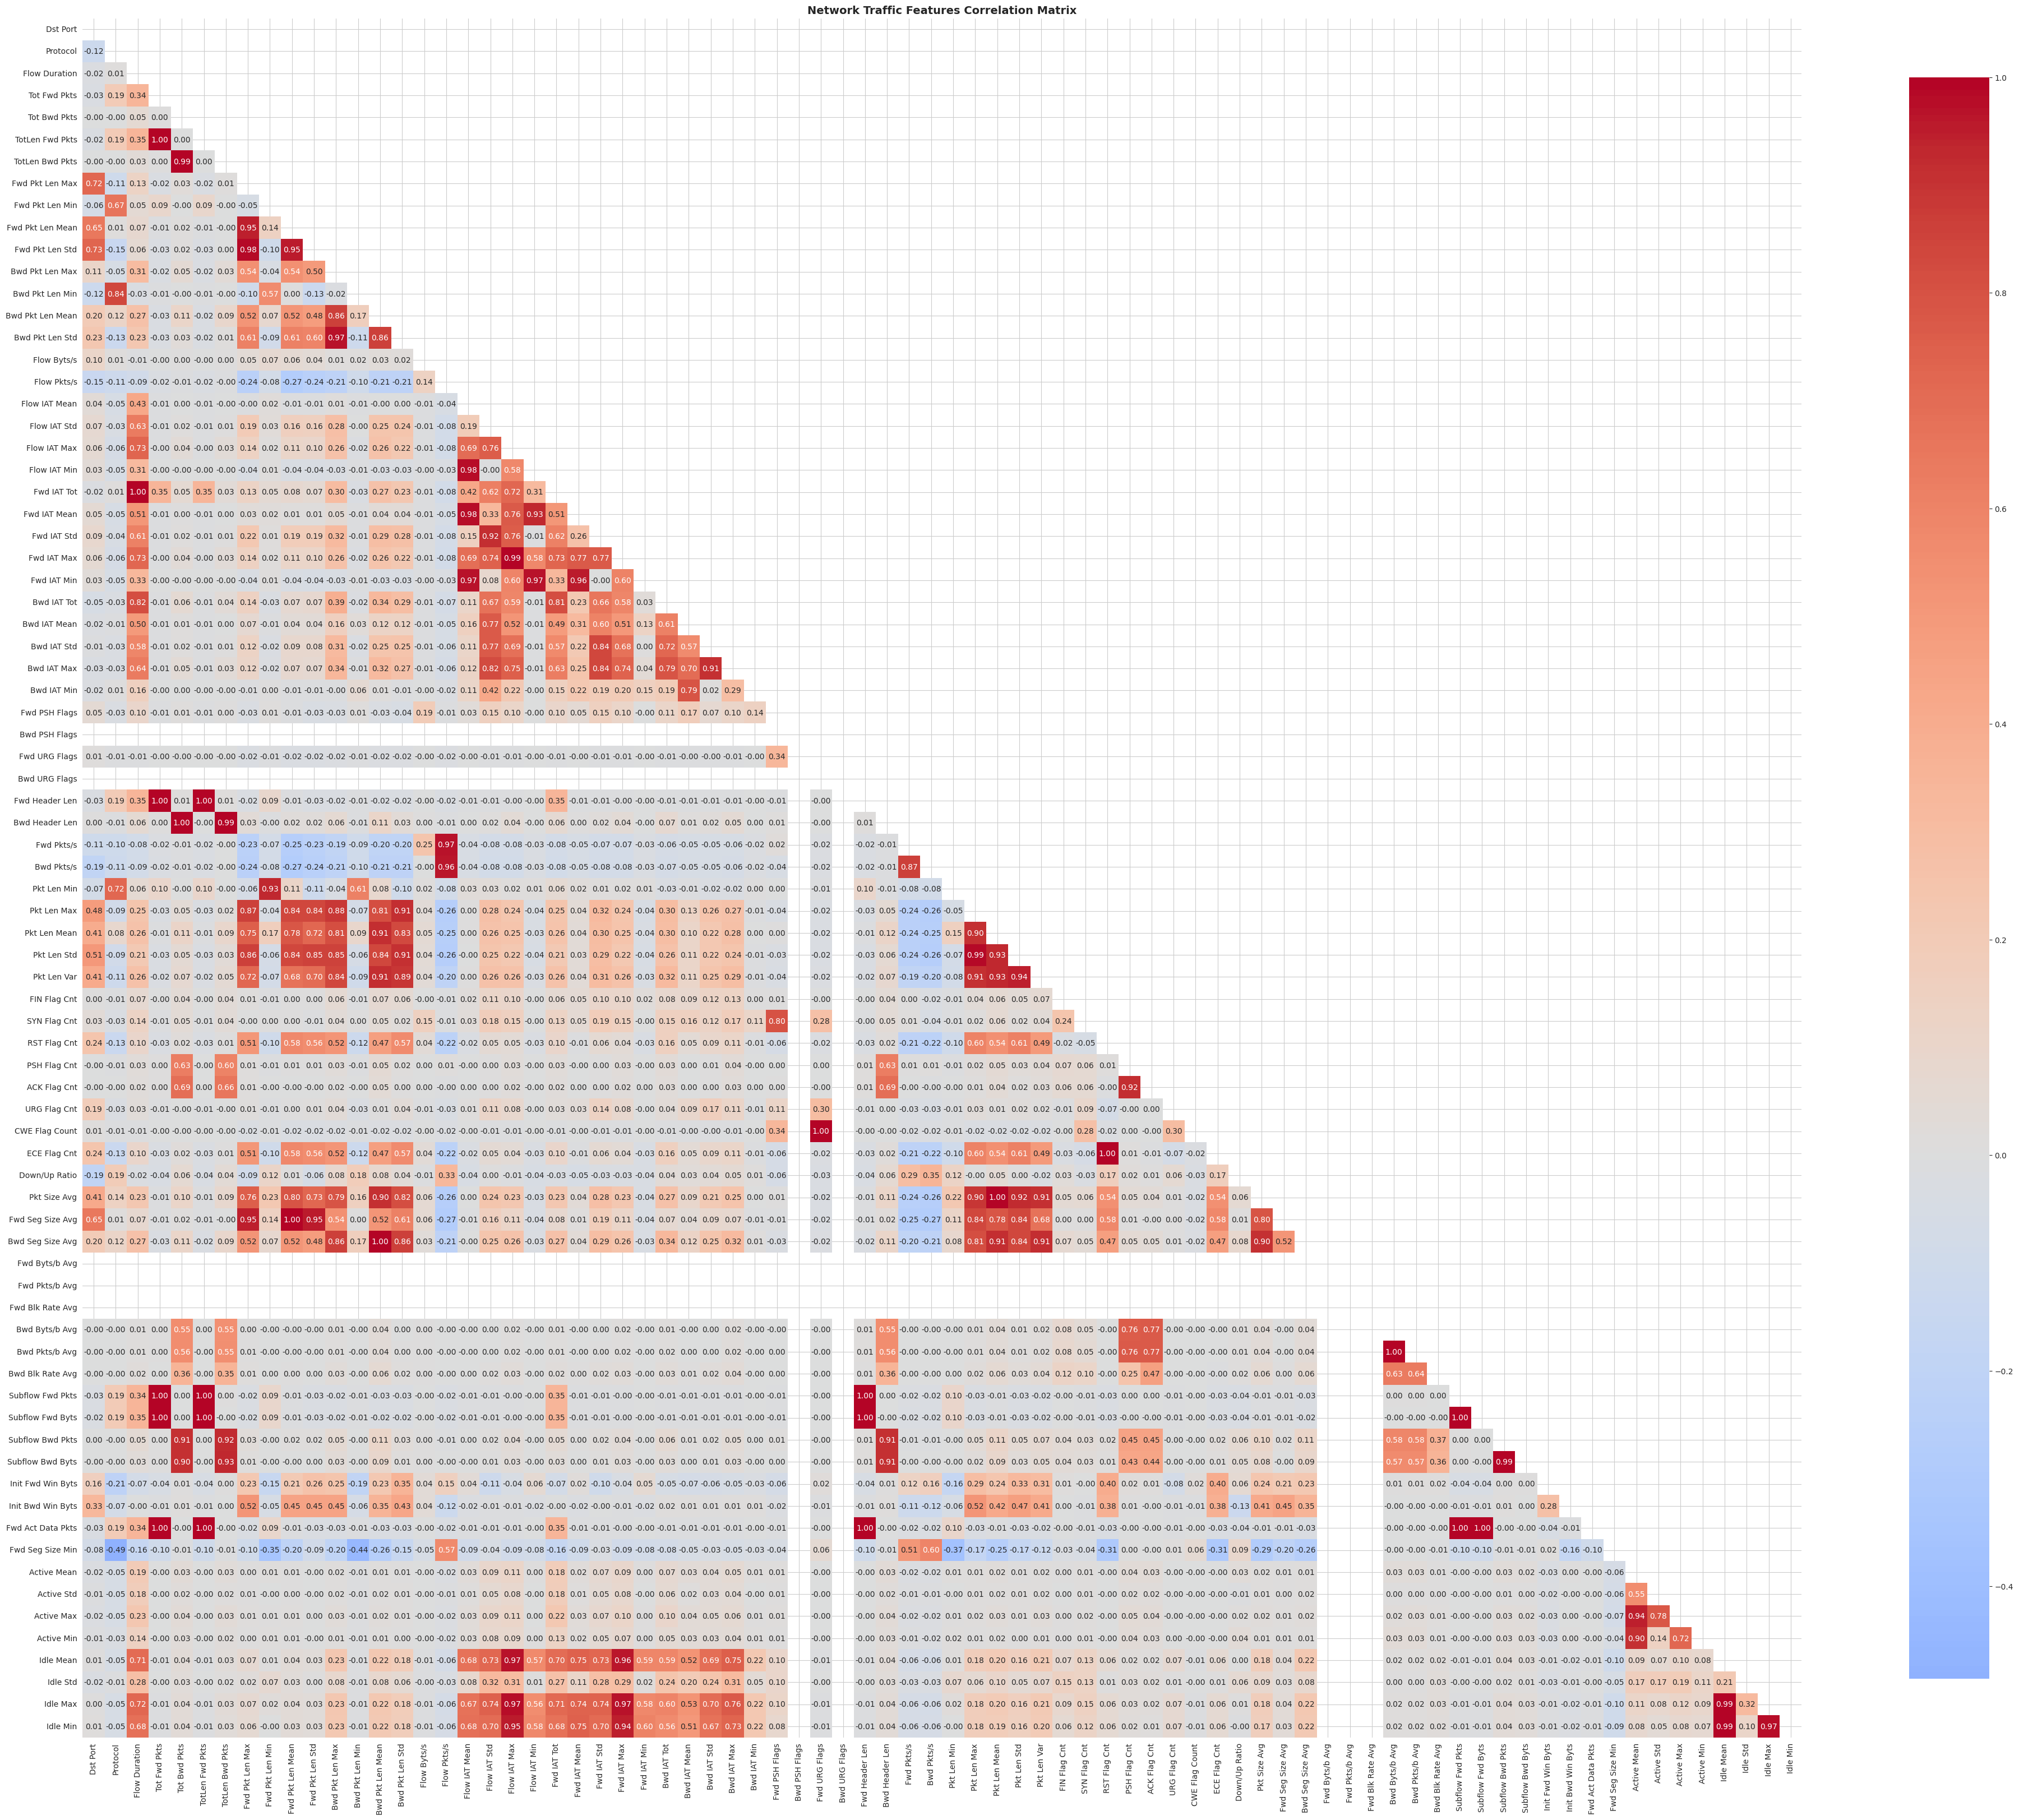

\correlations:
             Feature1           Feature2  Correlation
60   Bwd Pkt Len Mean   Bwd Seg Size Avg     1.000000
40   Fwd Pkt Len Mean   Fwd Seg Size Avg     1.000000
21    TotLen Fwd Pkts   Subflow Fwd Byts     0.999999
12       Tot Fwd Pkts   Subflow Fwd Pkts     0.999995
152  Subflow Fwd Pkts  Fwd Act Data Pkts     0.999991
14       Tot Fwd Pkts  Fwd Act Data Pkts     0.999986
11       Tot Fwd Pkts     Fwd Header Len     0.999937
119    Fwd Header Len   Subflow Fwd Pkts     0.999915
121    Fwd Header Len  Fwd Act Data Pkts     0.999869
150    Bwd Byts/b Avg     Bwd Pkts/b Avg     0.999832


In [15]:
def correlation_analysis(df):
    numeric_df = df.select_dtypes(include=[np.number])

    correlation_matrix = numeric_df.corr()

    # Heatmap
    plt.figure(figsize=(40, 36))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix,
                mask=mask,
                annot=True,
                cmap='coolwarm',
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8})
    plt.title('Network Traffic Features Correlation Matrix', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()
    print("\correlations:")
    high_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                high_corr.append({
                    'Feature1': correlation_matrix.columns[i],
                    'Feature2': correlation_matrix.columns[j],
                    'Correlation': correlation_matrix.iloc[i, j]
                })

    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.head(10))

    return correlation_matrix

corr_matrix = correlation_analysis(df_clean)

Bu fonksiyon, **Isolation Forest** algoritması kullanarak ağ trafiğindeki anormal davranışları tespit ediyor. İşlem adımları şöyle:

1. Sayısal özellikler seçilip **StandardScaler** ile ölçekleniyor.  
2. Isolation Forest, belirtilen %10 anomali oranıyla modeli eğitip, her veri noktasına anomali puanı ve etiketi atıyor.  
3. Sonuçlar, normal ve anormal bağlantıların sayısal ve yüzde bazında dağılımı ile ekrana basılıyor:  
   - Normal veri %90 civarında, anomali ise %10 olarak tespit edilmiş.  
4. Anomali skorlarının dağılımı histogram olarak gösteriliyor; kırmızı çizgi, anomali eşik değerini (0) simgeliyor.  
5. Son olarak, veriyi 2 bileşene indirgenmiş PCA uzayında noktalar renk kodlarıyla görselleştiriliyor. Böylece anomali ve normal veri noktalarının uzaydaki dağılımı anlaşılabiliyor.

- %10 anomali oranı, veri setinin doğasından (CICIDS2018) kaynaklıdır ve model parametresi olarak verilmiştir.  
- PCA grafiği anomali ve normal verilerin ne kadar iyi ayrıştığı hakkında görsel fikir verir, ama gerçek performans metrikleri ayrıca hesaplanmalı.  

Normal : 267,235 (%90.00)
Anomaly : 29,691 (%10.00)


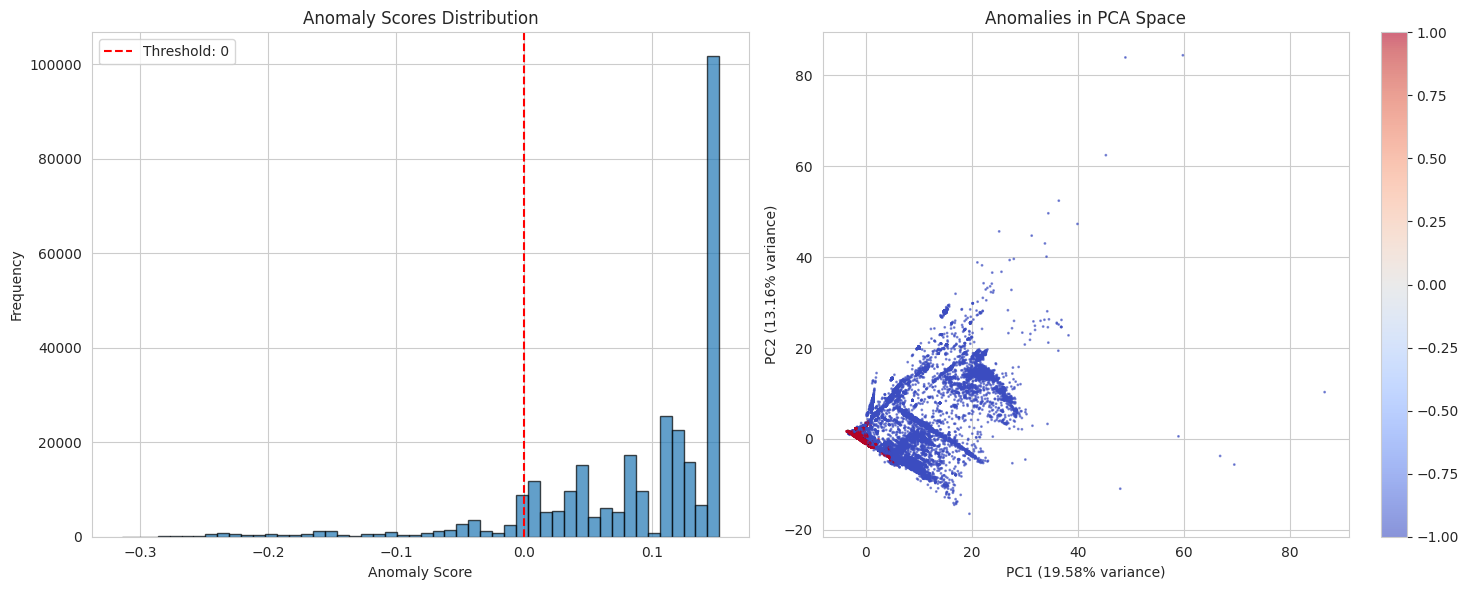

In [16]:
def anomaly_detection(df):

    numeric_df = df.select_dtypes(include=[np.number]).fillna(0)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df)


    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    anomalies = iso_forest.fit_predict(scaled_data)

    anomaly_scores = iso_forest.decision_function(scaled_data)

    df['Anomaly'] = anomalies
    df['Anomaly_Score'] = anomaly_scores

    normal_count = np.sum(anomalies == 1)
    anomaly_count = np.sum(anomalies == -1)

    print(f"Normal : {normal_count:,} (%{normal_count/len(df)*100:.2f})")
    print(f"Anomaly : {anomaly_count:,} (%{anomaly_count/len(df)*100:.2f})")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].hist(anomaly_scores, bins=50, alpha=0.7, edgecolor='black')
    threshold = 0
    axes[0].axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold}')
    axes[0].set_title('Anomaly Scores Distribution')
    axes[0].set_xlabel('Anomaly Score')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()

    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled_data)

    scatter = axes[1].scatter(pca_data[:, 0], pca_data[:, 1],
                             c=anomalies, cmap='coolwarm', alpha=0.6, s=1)
    axes[1].set_title('Anomalies in PCA Space')
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.colorbar(scatter, ax=axes[1])

    plt.tight_layout()
    plt.show()

    return df

df_with_anomalies = anomaly_detection(df_clean.copy())

Normal (benign) ağ trafiği, genellikle çok daha uzun süreli bağlantılardan oluşur ve süre dağılımı oldukça geniştir. Bu, bağlantıların çeşitlilik gösterdiğini ve bazıların çok uzun süre devam ettiğini gösterir.

Öte yandan, saldırı amaçlı trafik genellikle kısa ve yoğun akışlardan meydana gelir; bağlantılar daha kısa sürer ve süreler arasında daha az değişkenlik vardır.

Bu temel fark, modelin normal ve anormal davranışları ayırt etmesinde önemli bir özellik olarak kullanılabilir.

 Analyzed column: Flow Duration

BENIGN TRAFFIC


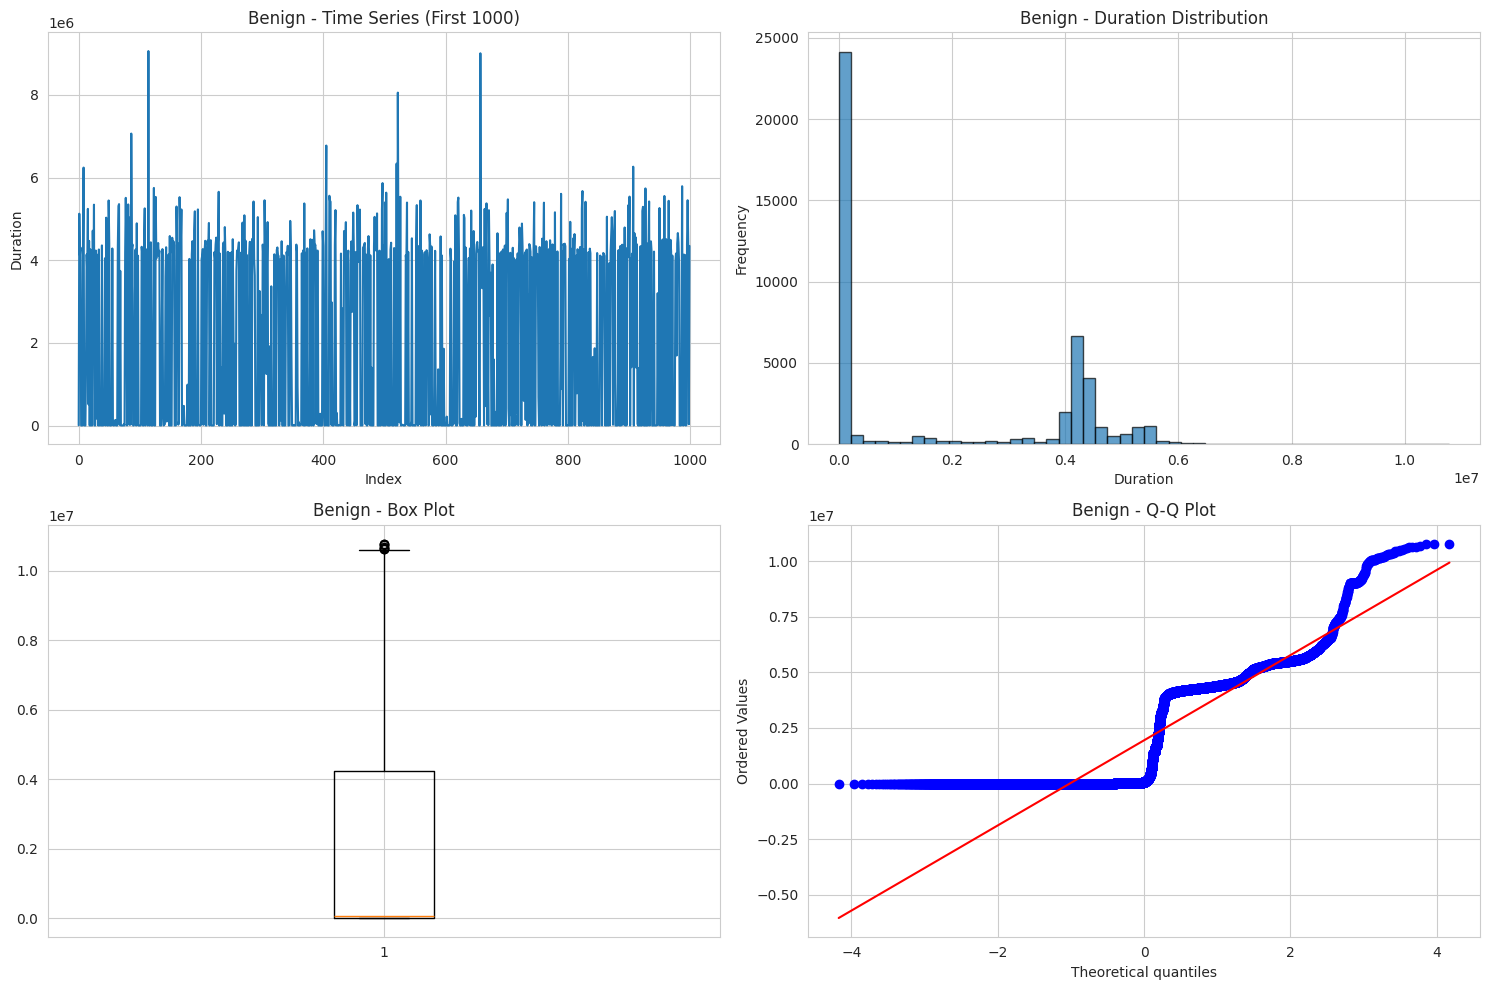

📊 Benign Flow Duration :
Mean: 1944418.13
Median: 66172.00
Std Deviation: 2212519.99
Min: 1.00
Max: 10787106.00

ANOMALY TRAFFIC


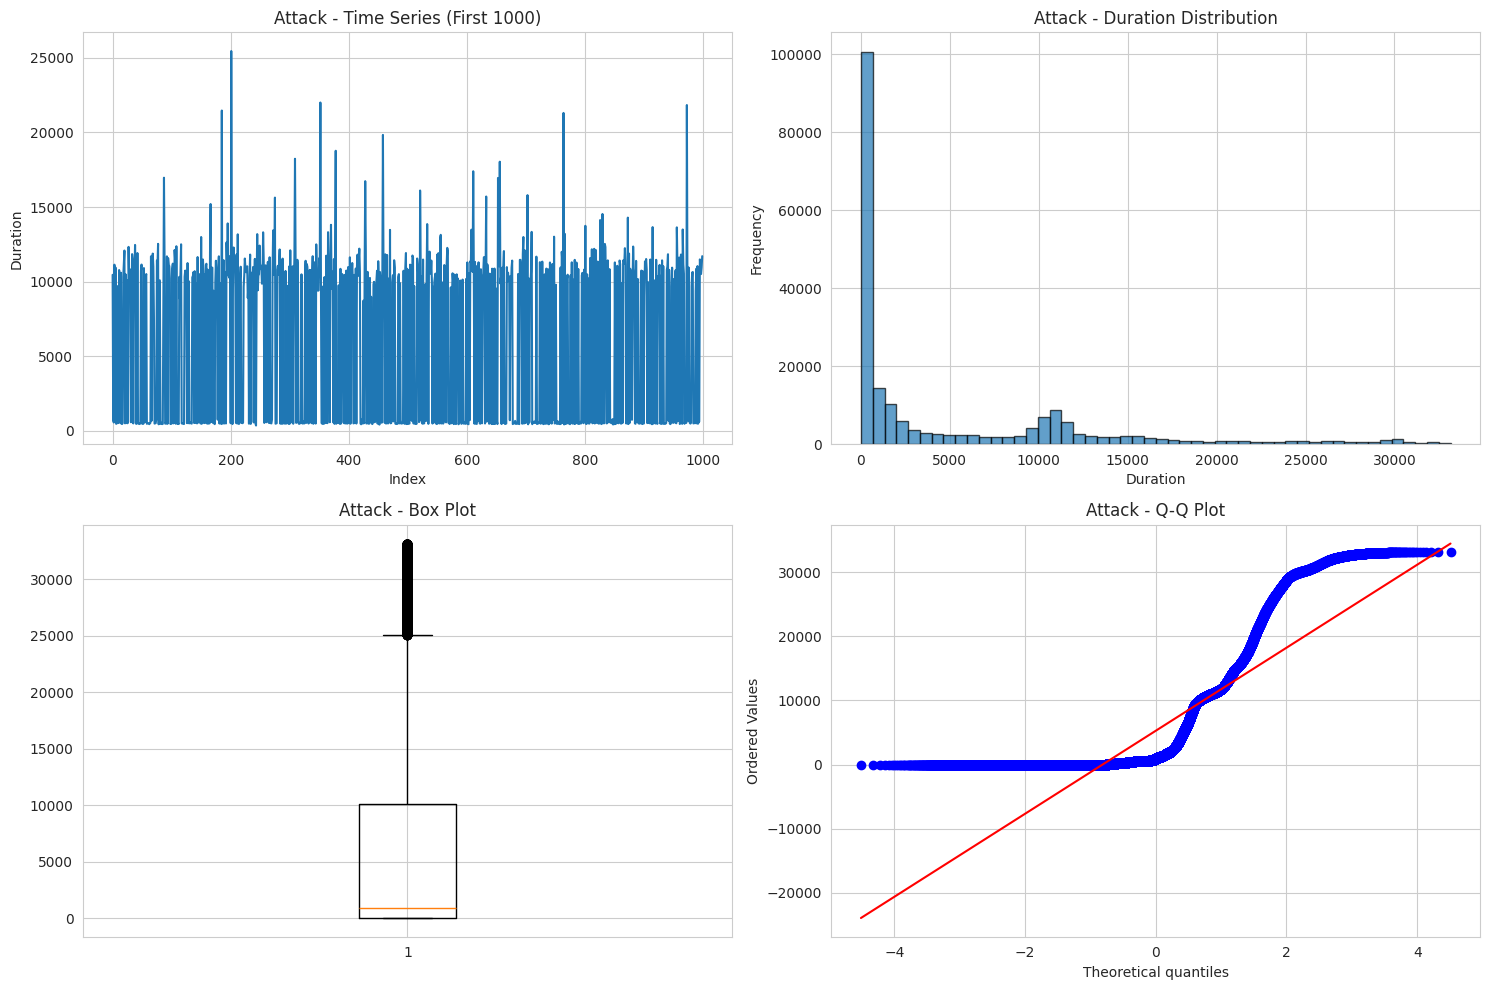

📊 Attack Flow Duration :
Mean: 5270.36
Median: 914.00
Std Deviation: 7592.00
Min: 1.00
Max: 33150.00



In [17]:
def time_series_analysis_by_label(df):

    duration_cols = [col for col in df.columns if 'duration' in col.lower() or 'süre' in col.lower()]

    duration_col = duration_cols[0]
    print(f" Analyzed column: {duration_col}\n")

    benign_df = df[df['Label'] == 'Benign']
    attack_df = df[df['Label'] != 'Benign']

    def analyze_and_plot(data, title_prefix):

        Q1 = data[duration_col].quantile(0.25)
        Q3 = data[duration_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        clean = data[(data[duration_col] >= lower) & (data[duration_col] <= upper)][duration_col]

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        axes[0, 0].plot(clean.values[:1000])
        axes[0, 0].set_title(f'{title_prefix} - Time Series (First 1000)')
        axes[0, 0].set_xlabel('Index')
        axes[0, 0].set_ylabel('Duration')

        axes[0, 1].hist(clean, bins=50, alpha=0.7, edgecolor='black')
        axes[0, 1].set_title(f'{title_prefix} - Duration Distribution')
        axes[0, 1].set_xlabel('Duration')
        axes[0, 1].set_ylabel('Frequency')

        axes[1, 0].boxplot(clean)
        axes[1, 0].set_title(f'{title_prefix} - Box Plot')

        stats.probplot(clean, dist="norm", plot=axes[1, 1])
        axes[1, 1].set_title(f'{title_prefix} - Q-Q Plot')

        plt.tight_layout()
        plt.show()

        print(f"📊 {title_prefix} Flow Duration :")
        print(f"Mean: {clean.mean():.2f}")
        print(f"Median: {clean.median():.2f}")
        print(f"Std Deviation: {clean.std():.2f}")
        print(f"Min: {clean.min():.2f}")
        print(f"Max: {clean.max():.2f}\n")

    print("BENIGN TRAFFIC")
    analyze_and_plot(benign_df, "Benign")

    print("ANOMALY TRAFFIC")
    analyze_and_plot(attack_df, "Attack")

time_series_analysis_by_label(df_clean)



Bayrak kombinasyonları, TCP bağlantı durumları (örneğin SYN, ACK, FIN gibi) ve saldırı türlerinin belirlenmesinde kritik öneme sahiptir.

In [18]:
def protocol_analysis(df):

    flag_cols = [col for col in df.columns if 'flag' in col.lower() or 'Flag' in col]

    if len(flag_cols) >= 3:
        print(f"\n Most Common Flag Combinations:")

        top_flags = df[flag_cols[:3]].value_counts().reset_index(name='count')
        top_flags = top_flags.head(10)

        print(top_flags.to_string(index=False))

protocol_analysis(df_clean)


 Most Common Flag Combinations:
 Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  count
             0              0              0 293167
             1              0              0   3319
             1              0              1    440


Modelin yüksek doğruluk ve dengeli performansı, ağ trafiği anomali tespitinde kullanılmaya uygun olduğunu gösteriyor. Özellikle kritik saldırı türlerini başarılı yakalaması projenin başarısını pekiştiriyor. Ancak benign sınıfındaki recall’un artırılması, yanlış alarm oranının düşürülmesi için bir sonraki hedef olabilir.

GPU : 1
Epoch 1/3
836/836 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8230 - loss: 0.5414 - val_accuracy: 0.9451 - val_loss: 0.1250
Epoch 2/3
836/836 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9409 - loss: 0.1355 - val_accuracy: 0.9474 - val_loss: 0.1157
Epoch 3/3
836/836 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9450 - loss: 0.1238 - val_accuracy: 0.9491 - val_loss: 0.1109
1856/1856 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 Classification Report:

                          precision    recall  f1-score   support

                  Benign       0.99      0.70      0.82      9975
                     Bot       1.00      1.00      1.00     10000
        DDOS attack-HOIC       1.00      1.00      1.00     10000
    DDOS attack-LOIC-UDP       1.00      0.99      1.00       173
        DoS attacks-Hulk       1.00      1.00      1.00     10000
DoS attacks-SlowHTTPTest       1.00      1.00      1.00     10000
           Infilteration       0.75      0.99      0.86      9238

            

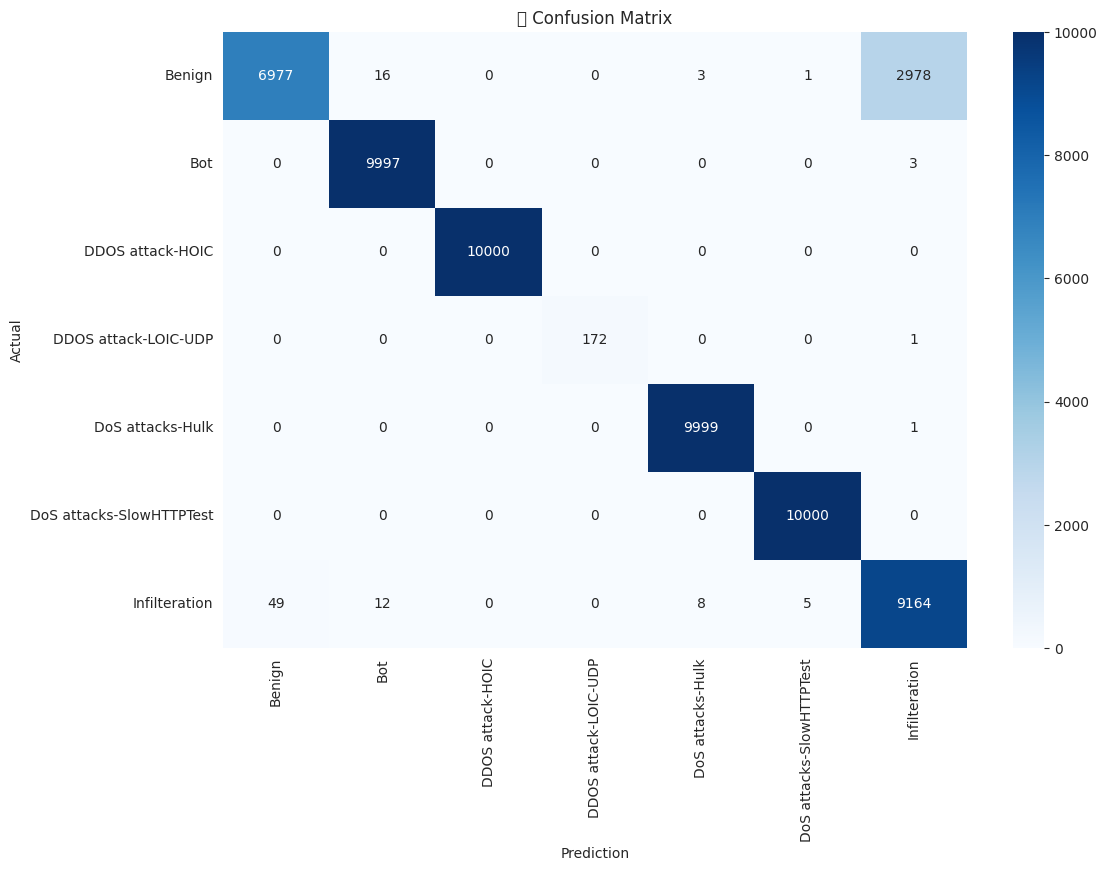

In [30]:

gpus = tf.config.list_physical_devices('GPU')
print(f"GPU : {len(gpus)}")


X = df_clean.drop("Label", axis=1)
y = df_clean["Label"]


le = LabelEncoder()
y_encoded = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

device = '/GPU:0' if gpus else '/CPU:0'
with tf.device(device):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(len(le.classes_), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train_scaled, y_train,
              epochs=3,
              batch_size=256,
              validation_split=0.1,
              verbose=1)


y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)


print("\n Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('🔍 Confusion Matrix')
plt.show()


Training..

📊 SVM Classification Report:

                          precision    recall  f1-score   support

                  Benign       0.99      0.72      0.84      9975
                     Bot       0.97      1.00      0.99     10000
        DDOS attack-HOIC       1.00      1.00      1.00     10000
    DDOS attack-LOIC-UDP       1.00      0.99      1.00       173
        DoS attacks-Hulk       1.00      1.00      1.00     10000
DoS attacks-SlowHTTPTest       1.00      1.00      1.00     10000
           Infilteration       0.77      0.97      0.86      9238

                accuracy                           0.95     59386
               macro avg       0.96      0.95      0.95     59386
            weighted avg       0.96      0.95      0.95     59386



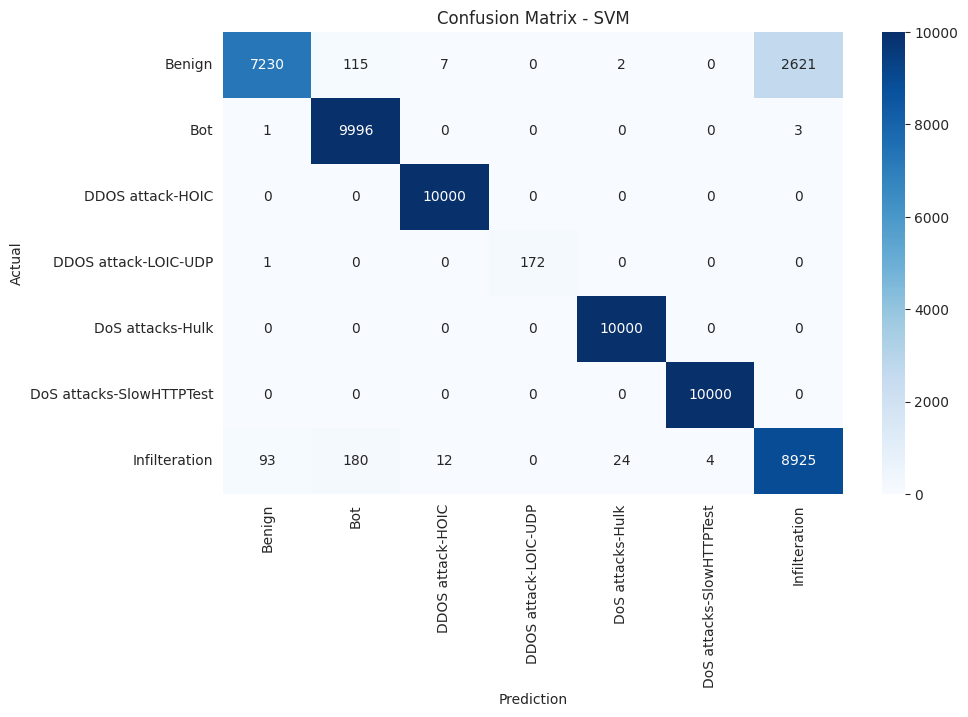


📊 KNN Classification Report:

                          precision    recall  f1-score   support

                  Benign       0.89      0.80      0.84      9975
                     Bot       1.00      1.00      1.00     10000
        DDOS attack-HOIC       1.00      1.00      1.00     10000
    DDOS attack-LOIC-UDP       1.00      1.00      1.00       173
        DoS attacks-Hulk       1.00      1.00      1.00     10000
DoS attacks-SlowHTTPTest       1.00      1.00      1.00     10000
           Infilteration       0.80      0.90      0.85      9238

                accuracy                           0.95     59386
               macro avg       0.96      0.96      0.96     59386
            weighted avg       0.95      0.95      0.95     59386



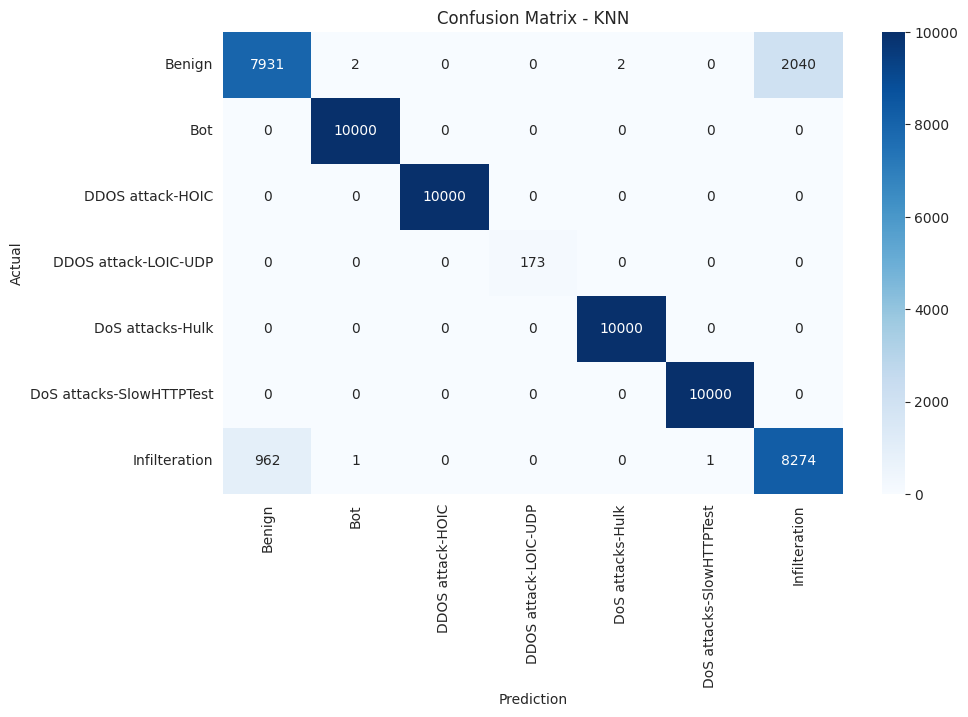


📊 Random Forest Classification Report:

                          precision    recall  f1-score   support

                  Benign       0.89      0.81      0.85      9975
                     Bot       1.00      1.00      1.00     10000
        DDOS attack-HOIC       1.00      1.00      1.00     10000
    DDOS attack-LOIC-UDP       1.00      1.00      1.00       173
        DoS attacks-Hulk       1.00      1.00      1.00     10000
DoS attacks-SlowHTTPTest       1.00      1.00      1.00     10000
           Infilteration       0.81      0.89      0.85      9238

                accuracy                           0.95     59386
               macro avg       0.96      0.96      0.96     59386
            weighted avg       0.95      0.95      0.95     59386



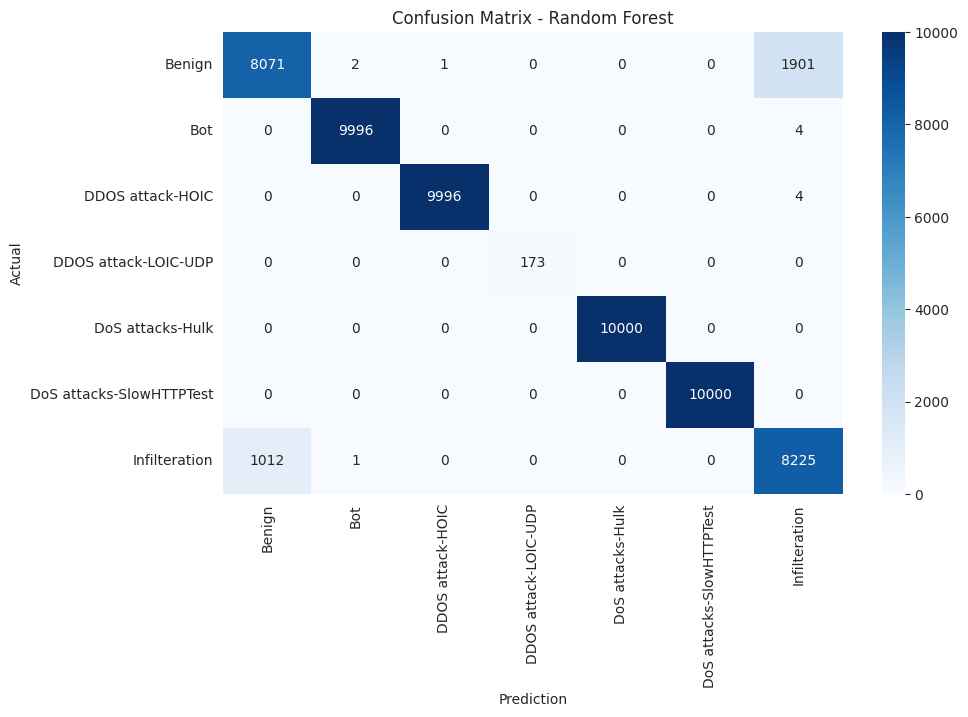


🔍 Model Accuracy Comparison:
SVM: 0.9484
KNN: 0.9493
Random Forest: 0.9507


In [21]:
from sklearn.metrics import accuracy_score
models = {
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
print("Training..")
for name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n📊 {name} Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=le.classes_))


    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.show()


print("\n🔍 Model Accuracy Comparison:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")

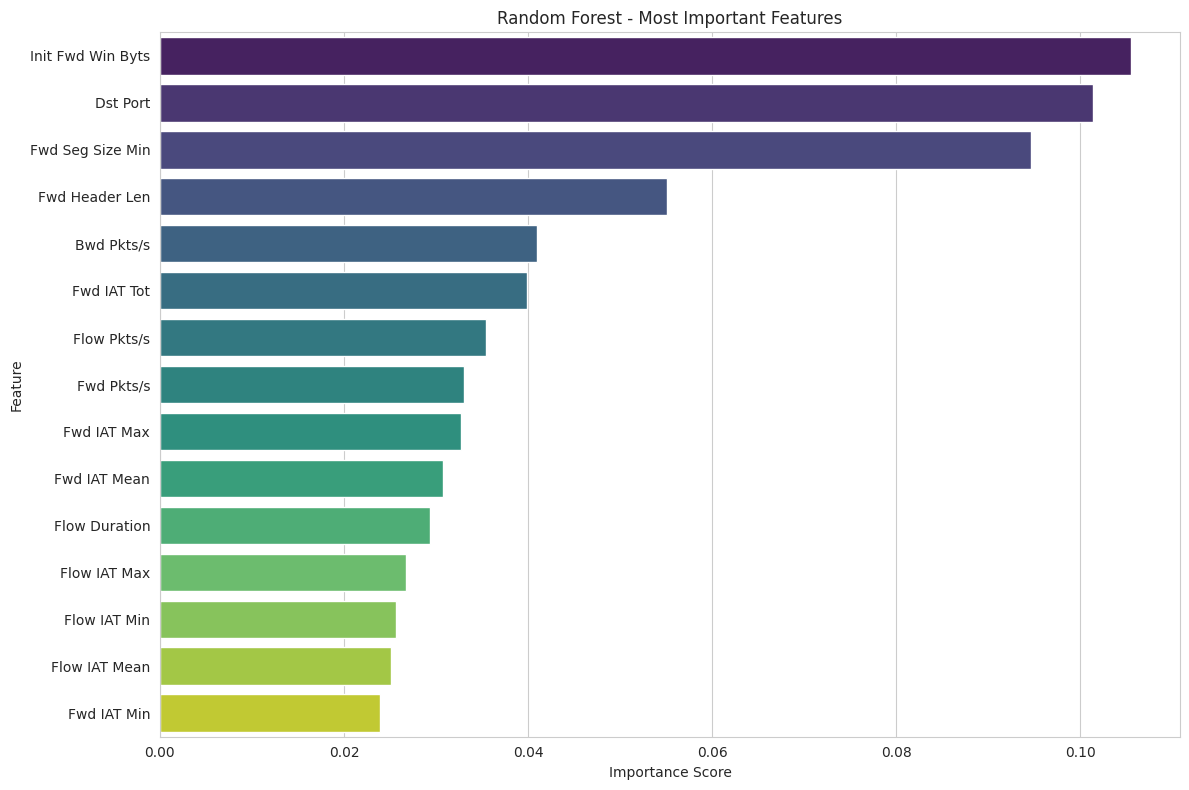

In [49]:
importances = models["Random Forest"].feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(15), palette="viridis")
plt.title("Random Forest - Most Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


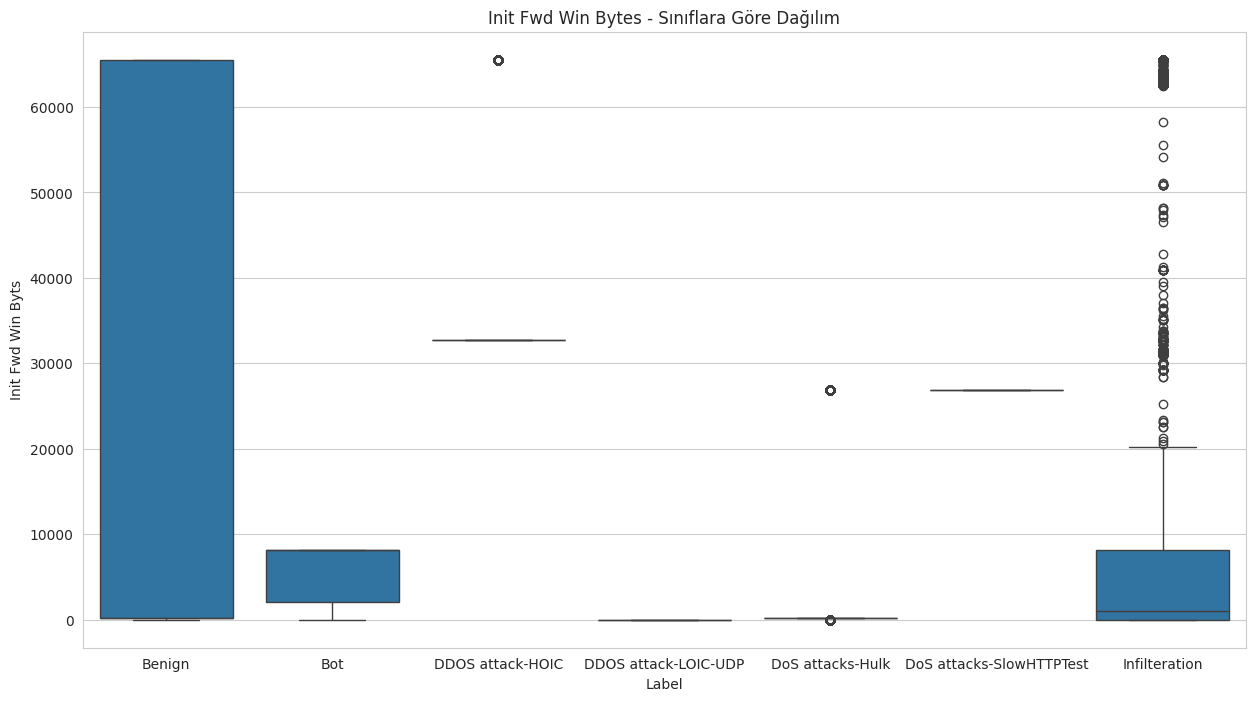

In [47]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="Label", y="Init Fwd Win Byts", data=df_clean)
plt.title("Init Fwd Win Bytes - Sınıflara Göre Dağılım")
plt.show()

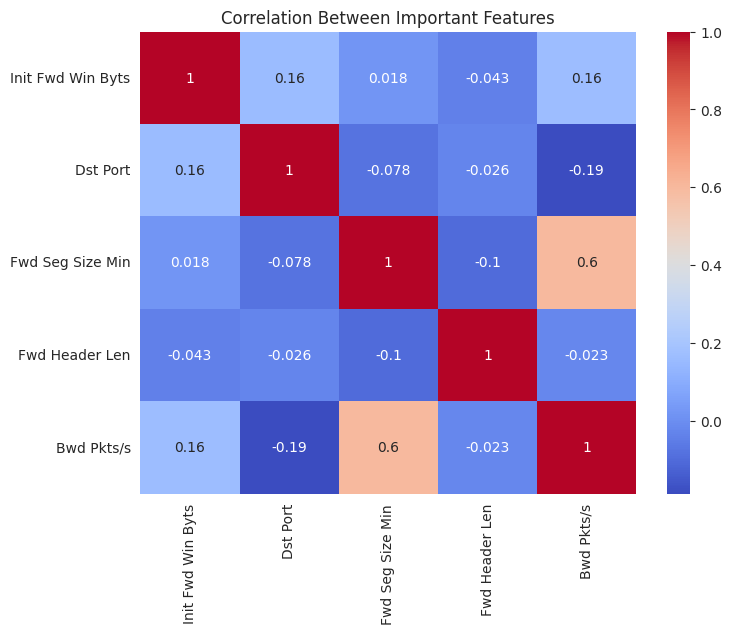

In [46]:
important_features = ["Init Fwd Win Byts", "Dst Port", "Fwd Seg Size Min", "Fwd Header Len", "Bwd Pkts/s"]
corr = df_clean[important_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Important Features")
plt.show()

Fwd Header Len (İleri Başlık Uzunluğu): DDOS attack-LOIC-UDP sınıfı bu özellikte açık ara en yüksek ortalamaya sahip. Bu, bu saldırının büyük boyutlu başlıklarla çalıştığını gösterir.

Bwd Pkts/s (Geri Paket Hızı): DoS attacks-SlowHTTPTest saldırısı çok yüksek geri paket gönderme oranına sahip. Bu, sunucunun yanıt kapasitesini tüketmeye yönelik bir davranış olabilir.

Init Fwd Win Byts: DDOS attack-HOIC bu alanda öne çıkıyor. Bu, iletim penceresi boyutunun büyük olduğunu gösterir, bu da daha agresif veri iletimi anlamına gelebilir.

Dst Port: Infiltration sınıfı diğerlerinden belirgin şekilde yüksek bir ortalamaya sahip. Bu, hedeflenen portların spesifik ve yüksek sayılarda olmasıyla ilişkilendirilebilir.

Fwd Seg Size Min: Tüm sınıflarda çok küçük ya da sıfıra yakın. Bu özellik ayrıştırıcı değil gibi görünüyor.

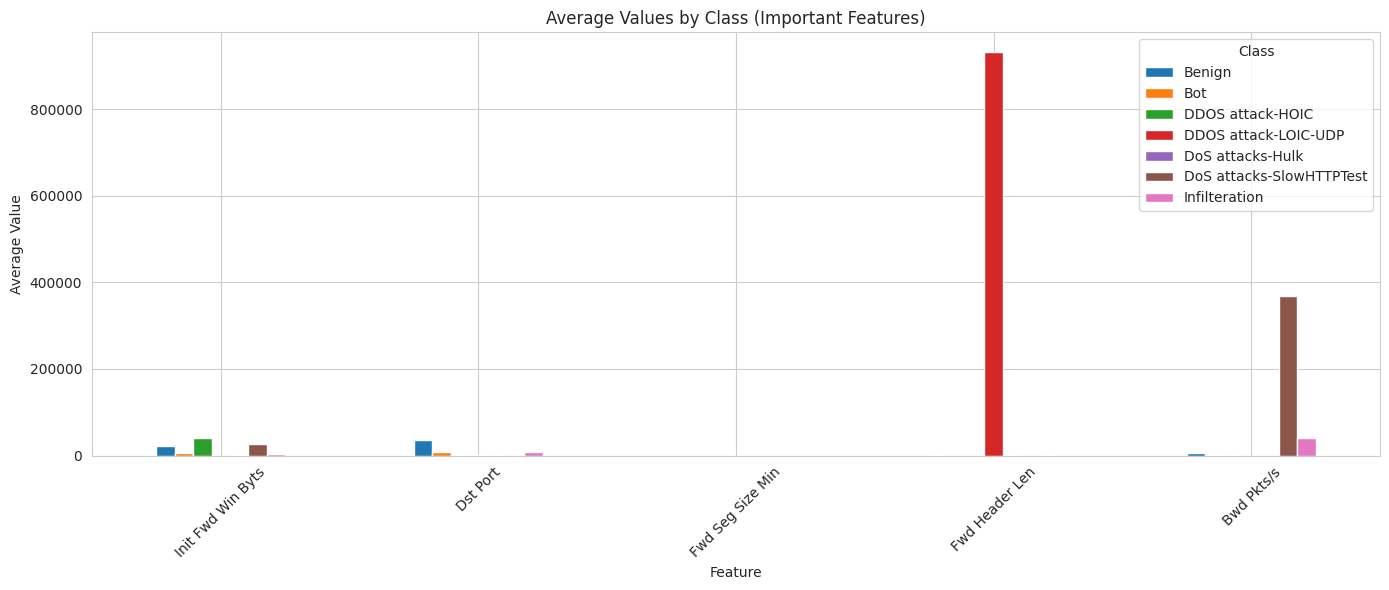

In [45]:
df_clean.groupby("Label")[important_features].mean().T.plot(kind="bar", figsize=(14, 6))
plt.title("Average Values by Class (Important Features)")
plt.ylabel("Average Value")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.legend(title="Class")
plt.tight_layout()
plt.show()

In [44]:
def format_number(num):
    if abs(num) >= 1_000_000:
        return f"{num / 1_000_000:.2f} M"
    elif abs(num) >= 1_000:
        return f"{num / 1_000:.1f} K"
    else:
        return f"{num:.2f}"

df_temp = df_clean.copy()
df_temp["BinaryLabel"] = df_temp["Label"].apply(lambda x: "Benign" if x == "Benign" else "Malicious")

numeric_cols = df_temp.select_dtypes(include=np.number).columns

diffs = []
for col in numeric_cols:
    benign_mean = df_temp[df_temp["BinaryLabel"] == "Benign"][col].mean()
    malicious_mean = df_temp[df_temp["BinaryLabel"] == "Malicious"][col].mean()
    diff = abs(benign_mean - malicious_mean)
    diffs.append((col, diff))

diffs_sorted = sorted(diffs, key=lambda x: x[1], reverse=True)

print(" The most significant differences between the Benign and Malignant classes:\n")
for i, (col, diff) in enumerate(diffs_sorted[:10], 1):
    print(f"{i}. {col:<25} → Average difference: {format_number(diff)}")


 The most significant differences between the Benign and Malignant classes:

1. Flow Duration             → Average difference: 5.83 M
2. Fwd IAT Tot               → Average difference: 5.80 M
3. Flow IAT Max              → Average difference: 4.13 M
4. Fwd IAT Max               → Average difference: 4.13 M
5. Bwd IAT Tot               → Average difference: 2.73 M
6. Idle Max                  → Average difference: 2.56 M
7. Idle Mean                 → Average difference: 2.46 M
8. Idle Min                  → Average difference: 2.35 M
9. Fwd IAT Mean              → Average difference: 1.97 M
10. Flow IAT Mean             → Average difference: 1.58 M
